In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from io import StringIO
import scipy.special as scp
from scipy.optimize import curve_fit, leastsq 
from sklearn.linear_model import LinearRegression
import os
import datetime as dt
from datetime import datetime
import statistics
#%matplotlib inline

sns.set_style("whitegrid", {'grid.linestyle': '--'})
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [87]:
df = pd.read_excel(r"C:\Users\jfrank\OneDrive - Specialized Bicycle Components\Projects\MetFit2.0\20200708 Jesse Frank (MC_BasebarWashout).xlsx")
df.head()

# Start Pre-Procession Data Files
df = df.iloc[:, 9:] #Get rid of the first 9 columns

for col in df.columns: #Combine units with Column name via UNderscore
    df.rename(columns = {col:col+'_'+df.loc[0, col]}, inplace=True)
df.head()    

#Delete first 2 rows with units and NAN
df = df.drop([0,1])
df = df.reset_index(drop=True)
df.head()


#Convert time data series to seconds and add new column
df['seconds']= df['t_s'].apply(lambda x:(x.hour * 60 + x.minute) * 60 + x.second)

df.head()
#df.info()

t_s    Rf_1/min VT_L(btps)    VE_L/min IV_mL    VO2_mL/min  \
0  00:00:19 44.40000000 0.91000000 40.40000000  1654 1752.23452170   
1  00:00:21 31.20000000 1.95500000          61  1985 2645.70063910   
2  00:00:22 35.20000000 2.23300000 78.60000000  1309 3409.05033170   
3  00:00:24 48.70000000 1.31000000 63.80000000  1160 2767.14263570   
4  00:00:25 51.70000000 1.18800000 61.40000000   911 2663.04949580   

    VCO2_mL/min     RQ_---  VE/VO2_--- VE/VCO2_---  ... CO2 Delay_ms  \
0 1280.34068560 0.73000000 21.30000000 29.10000000  ...          680   
1 1933.18766880 0.73000000 22.20000000 30.40000000  ...          680   
2 2490.95984870 0.73000000 22.30000000 30.60000000  ...          680   
3 2021.92415200 0.73000000 21.80000000 29.90000000  ...          680   
4 1945.86430930 0.73000000 21.70000000 29.70000000  ...          680   

  GPS Heading_DEG Bike Wheel Cadence_rpm Bike Power_Watt RH Sample_%  \
0               0                    378             130          77   
1               0                    386             130          77   
2               0                    388             130          77   
3               0                    388             130          77   
4               0                    387             130          77   

  Satellites_--- Fixing_--- Satellites SNR_dB HRR_bpm seconds  
0              9      False                27      79      19  
1              9      False                27      78      21  
2              9      False                27      77      22  
3              9      False                27      78      24  
4              9      False                27      78      25  

[5 rows x 66 columns]

In [204]:
#df["seconds"] = df["seconds"].astype('object')
#df.info()

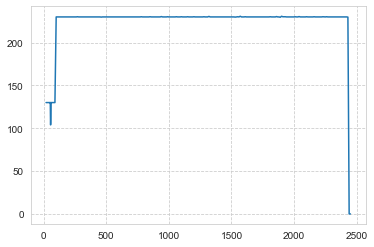

In [3]:
plt.plot(df["seconds"],df["Bike Power_Watt"])

In [88]:
#data we care about
df_care = df.iloc[30:-2]
#df_care = df_care.astype('int')
df_care.head()
df_care["seconds"] = df_care["seconds"] - df_care["seconds"].iloc[0]
#df_care.info()
#for index in df_care["seconds"]:
    #df_care['seconds'] = df_care['seconds'].iloc[index]-df_care['seconds'].iloc[2]
#df_care.iloc[0]#["Bike Power_Watt"]
#df_care['seconds']
df_care.head()
#df_care.info()

C:\Users\jfrank\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


t_s    Rf_1/min VT_L(btps)    VE_L/min IV_mL    VO2_mL/min  \
30  00:01:30          38 1.32600000 50.40000000  1034 2352.20668750   
31  00:01:40 33.50000000 1.42100000 47.60000000     0 2235.02294880   
32  00:01:50 32.40000000 1.45400000 47.10000000  1222 2227.95548270   
33  00:02:00 33.90000000 1.46900000 49.80000000  1453 2362.73172690   
34  00:02:10 47.50000000 1.04600000 49.70000000  1629 2356.91203400   

     VCO2_mL/min     RQ_---  VE/VO2_--- VE/VCO2_---  ... CO2 Delay_ms  \
30 1893.75064140 0.81000000 20.30000000 25.20000000  ...          680   
31 1811.87727990 0.81000000 20.20000000          25  ...          680   
32 1804.38600660 0.81000000 20.10000000 24.80000000  ...          680   
33 1920.02890530 0.81000000 20.10000000 24.70000000  ...          680   
34 1920.23554440 0.81000000 19.70000000 24.20000000  ...          680   

   GPS Heading_DEG Bike Wheel Cadence_rpm Bike Power_Watt RH Sample_%  \
30               0                    377             130          74   
31               0                    362             230          74   
32               0                    340             230          73   
33               0                    352             230          73   
34               0                    349             230          73   

   Satellites_--- Fixing_--- Satellites SNR_dB HRR_bpm seconds  
30              9      False                27      84       0  
31              9      False                27      86      10  
32              9      False                27      76      20  
33              9      False                27      74      30  
34              9      False                27      69      40  

[5 rows x 66 columns]

In [89]:
#Isolate only the variables that we want and chage Dtype from Object to float.
df_care_test = df_care[['VO2_mL/min',  'RQ_---','HR_bpm','EEm_kcal/min','Bike Power_Watt']]
df_care_test = df_care_test.astype(float)
df_care_test.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 30 to 260
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VO2_mL/min       231 non-null    float64
 1   RQ_---           231 non-null    float64
 2   HR_bpm           231 non-null    float64
 3   EEm_kcal/min     231 non-null    float64
 4   Bike Power_Watt  231 non-null    float64
dtypes: float64(5)
memory usage: 9.2 KB


In [31]:
""""
df_care_test['seconds_group'] = df_care['seconds'] // 180
df_grouped = pd.DataFrame(df_care_test.groupby('seconds_group').mean())
df_grouped['Pmet_Watt'] = df_grouped['EEm_kcal/min']*69.78
df_grouped['GME_%'] = df_grouped['Bike Power_Watt']/df_grouped['EEm_kcal/min']
df_grouped.iloc[-2]= ((df_grouped.iloc[-2] + df_grouped.iloc[-1])/2)
df_grouped = df_grouped.iloc[:-1]
df_grouped

#df_grouped.seconds_group.rename(index={'0': 'b'})
#df_care_test.groupby('seconds_group').count()
#df_grouped.iloc[-1]

#df_grouped.iloc[9] = 
#print(df_grouped)
#df_care_test.iloc[2]

#df_care
#df_g = pd.DataFrame(df_care_test.groupby('seconds_group')['VO2_mL/min'].mean())
#df_g = pd.DataFrame()#columns = aa.groups
#aa.groups

VO2_mL/min     RQ_---       HR_bpm  EEm_kcal/min  \
seconds_group                                                       
0             2814.05158312 0.81222222 127.83333333   13.48944444   
1             3284.15169243 0.86611111 138.22222222   15.93555556   
2             3274.94351827 0.89000000 141.94444444   15.97666667   
3             3288.27760792 0.87666667 144.16666667   15.99444444   
4             3402.88651827 0.88833333 145.05555556   16.59777778   
5             3394.75653743 0.86500000 146.27777778   16.47111111   
6             3394.24628883 0.87611111 146.38888889   16.51055556   
7             3335.05720410 0.86866667 147.46666667   16.19466667   
8             3355.96520496 0.87500000 147.94444444   16.31722222   
9             3370.59553761 0.87000000 150.11111111   16.37055556   
10            3515.10976641 0.88722222 150.38888889   17.13833333   
11            3362.50350627 0.86588235 150.52941176   16.31647059   
12            3362.08842193 0.86638889 150.97222222   16.32000000   

               Bike Power_Watt     Pmet_Watt       GME_%  
seconds_group                                             
0                 224.44444444  941.29343333 16.63852395  
1                 230.01111111 1111.98306667 14.43383071  
2                 229.98888889 1114.85180000 14.39529870  
3                 230.01111111 1116.09233333 14.38068774  
4                 230.03333333 1158.19293333 13.85928504  
5                 230.04444444 1149.35413333 13.96654074  
6                 230.05555556 1152.10656667 13.93384703  
7                 230.00000000 1130.06384000 14.20220649  
8                 230.05555556 1138.61576667 14.09894113  
9                 230.03333333 1142.33736667 14.05165100  
10                230.08888889 1195.91290000 13.42539466  
11                230.03529412 1138.56331765 14.09834884  
12                229.90555556 1138.80960000 14.08758165

In [91]:
df_care_test['seconds_group'] = df_care['seconds'] // 180
df_grouped = pd.DataFrame(df_care_test.groupby('seconds_group').mean())

df_grouped['Pmet_Watt'] = df_grouped['EEm_kcal/min']*69.78
df_grouped['GME_%'] = df_grouped['Bike Power_Watt']/df_grouped['EEm_kcal/min']
df_grouped.iloc[-2]= ((df_grouped.iloc[-2] + df_grouped.iloc[-1])/2)
df_grouped = df_grouped.iloc[:-1]
df_grouped
data = []
for index,val in enumerate(df_grouped["VO2_mL/min"]):
    data.append(dict(df_care_test.loc[df_care_test['seconds_group'] == index].iloc[-3:].mean()))
    
df_steady = pd.DataFrame(data)
df_steady
df_steady['Pmet_Watt'] = df_steady['EEm_kcal/min']*69.78
df_steady['GME_%'] = df_steady['Bike Power_Watt']/df_steady['EEm_kcal/min']
df_steady


VO2_mL/min     RQ_---       HR_bpm  EEm_kcal/min  Bike Power_Watt  \
0  3258.03312290 0.83333333 132.00000000   15.68666667     230.00000000   
1  3464.19136180 0.88666667 140.66666667   16.89000000     230.00000000   
2  3076.19583257 0.88333333 140.66666667   14.98000000     230.00000000   
3  3377.68275843 0.89000000 145.66666667   16.49000000     230.06666667   
4  3227.70672337 0.86666667 143.00000000   15.67000000     230.00000000   
5  3344.12023517 0.87333333 147.33333333   16.25333333     230.06666667   
6  3254.78649773 0.86666667 144.66666667   15.79666667     230.20000000   
7  3400.38271223 0.88666667 148.00000000   16.57000000     230.00000000   
8  3384.10647100 0.86000000 148.00000000   16.41333333     230.00000000   
9  3468.59454413 0.88666667 150.66666667   16.90666667     230.13333333   
10 3408.36642470 0.86000000 148.33333333   16.53333333     230.13333333   
11 3502.13335593 0.87666667 152.66666667   17.03666667     230.06666667   
12 3343.61301997 0.86333333 149.66666667   16.21666667     230.00000000   

    seconds_group     Pmet_Watt       GME_%  
0      0.00000000 1094.61560000 14.66213345  
1      1.00000000 1178.58420000 13.61752516  
2      2.00000000 1045.30440000 15.35380507  
3      3.00000000 1150.67220000 13.95189003  
4      4.00000000 1093.45260000 14.67772814  
5      5.00000000 1134.15760000 14.15504512  
6      6.00000000 1102.29140000 14.57269466  
7      7.00000000 1156.25460000 13.88050694  
8      8.00000000 1145.32240000 14.01299756  
9      9.00000000 1179.74720000 13.61198738  
10    10.00000000 1153.69600000 13.91935484  
11    11.00000000 1188.81860000 13.50420661  
12    12.00000000 1131.59900000 14.18293936

In [92]:
#Separate each condition into its on dataframe

df_base =pd.DataFrame([df_steady.iloc[0], df_steady.iloc[2], df_steady.iloc[4],df_steady.iloc[6],df_steady.iloc[8],df_steady.iloc[10],df_steady.iloc[12]])
std_base = df_up.std()
df_p1 =pd.DataFrame([df_steady.iloc[1], df_steady.iloc[11]])
std_p1 = df_down.std()
df_p2 =pd.DataFrame([df_steady.iloc[3], df_steady.iloc[9]])
std_p2 = df_down.std()
df_p3 =pd.DataFrame([df_steady.iloc[5], df_steady.iloc[7]])
std_p3 = df_down.std()


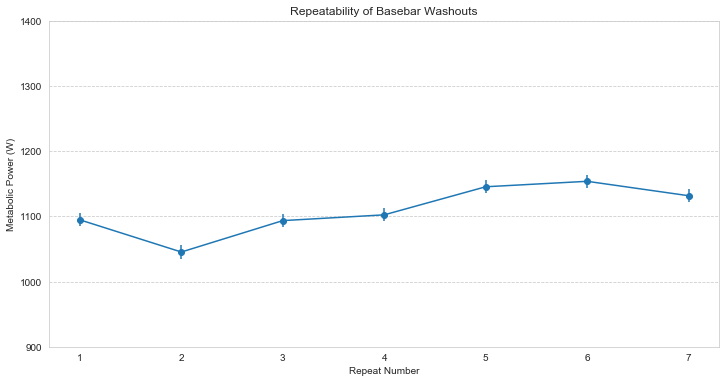

In [93]:
#Plot basebar washouts
plt.figure (figsize = (12, 6))
plt.title('Repeatability of Basebar Washouts')
plt.xlabel('Repeat Number')
plt.ylabel('Metabolic Power (W)')
plt.ylim(900, 1400)
plt.errorbar([1, 2, 3,4,5,6,7],df_base['Pmet_Watt'],yerr=std_base['Pmet_Watt'],fmt = 'o-')
plt.grid(axis = "x", which = "both")

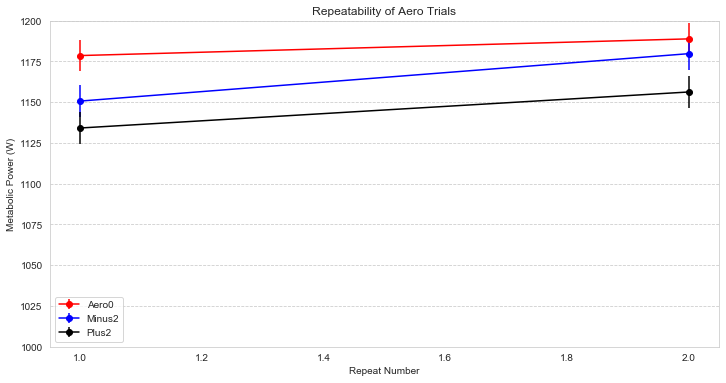

In [94]:
#Plot repeatability of positions
plt.figure (figsize = (12, 6))
plt.title('Repeatability of Aero Trials')
plt.xlabel('Repeat Number')
plt.ylabel('Metabolic Power (W)')
plt.ylim(1000, 1200)
plt.errorbar([1, 2],df_p1['Pmet_Watt'],yerr=std_p1['Pmet_Watt'],fmt = 'ro-')
plt.grid(axis = "x", which = "both")
plt.errorbar([1, 2],df_p2['Pmet_Watt'],yerr=std_p2['Pmet_Watt'],fmt = 'bo-')
plt.errorbar([1, 2],df_p3['Pmet_Watt'],yerr=std_p3['Pmet_Watt'],fmt = 'ko-')
plt.legend(['Aero0', 'Minus2','Plus2'])
plt.show()



In [95]:
df_grouped['Before Difference']= ""
df_grouped['After Difference']= ""
df_grouped['Sandwich Difference']= ""
for index in df_grouped.index:
    if (index % 2) == 1:
        df_grouped['Before Difference'].iloc[index] = df_grouped['Pmet_Watt'].iloc[index] - df_grouped['Pmet_Watt'].iloc[index-1]
        df_grouped['After Difference'].iloc[index] = df_grouped['Pmet_Watt'].iloc[index] - df_grouped['Pmet_Watt'].iloc[index+1]
        mean_diff = ((df_grouped['Pmet_Watt'].iloc[index+1]+df_grouped['Pmet_Watt'].iloc[index+1])//2)
        
        df_grouped['Sandwich Difference'].iloc[index] = (df_grouped['Pmet_Watt'].iloc[index] - mean_diff)
        
df_grouped

C:\Users\jfrank\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


VO2_mL/min     RQ_---       HR_bpm  EEm_kcal/min  \
seconds_group                                                       
0             2814.05158312 0.81222222 127.83333333   13.48944444   
1             3284.15169243 0.86611111 138.22222222   15.93555556   
2             3274.94351827 0.89000000 141.94444444   15.97666667   
3             3288.27760792 0.87666667 144.16666667   15.99444444   
4             3402.88651827 0.88833333 145.05555556   16.59777778   
5             3394.75653743 0.86500000 146.27777778   16.47111111   
6             3394.24628883 0.87611111 146.38888889   16.51055556   
7             3335.05720410 0.86866667 147.46666667   16.19466667   
8             3355.96520496 0.87500000 147.94444444   16.31722222   
9             3370.59553761 0.87000000 150.11111111   16.37055556   
10            3515.10976641 0.88722222 150.38888889   17.13833333   
11            3362.50350627 0.86588235 150.52941176   16.31647059   
12            3362.08842193 0.86638889 150.97222222   16.32000000   

               Bike Power_Watt     Pmet_Watt       GME_% Before Difference  \
seconds_group                                                                
0                 224.44444444  941.29343333 16.63852395                     
1                 230.01111111 1111.98306667 14.43383071      170.68963333   
2                 229.98888889 1114.85180000 14.39529870                     
3                 230.01111111 1116.09233333 14.38068774        1.24053333   
4                 230.03333333 1158.19293333 13.85928504                     
5                 230.04444444 1149.35413333 13.96654074       -8.83880000   
6                 230.05555556 1152.10656667 13.93384703                     
7                 230.00000000 1130.06384000 14.20220649      -22.04272667   
8                 230.05555556 1138.61576667 14.09894113                     
9                 230.03333333 1142.33736667 14.05165100        3.72160000   
10                230.08888889 1195.91290000 13.42539466                     
11                230.03529412 1138.56331765 14.09834884      -57.34958235   
12                229.90555556 1138.80960000 14.08758165                     

              After Difference Sandwich Difference  
seconds_group                                       
0                                                   
1                  -2.86873333         -2.01693333  
2                                                   
3                 -42.10060000        -41.90766667  
4                                                   
5                  -2.75243333         -2.64586667  
6                                                   
7                  -8.55192667         -7.93616000  
8                                                   
9                 -53.57553333        -52.66263333  
10                                                  
11                 -0.24628235          0.56331765  
12

In [96]:
p1 = df_grouped['Before Difference'].iloc[11]
p2 = (df_grouped['Before Difference'].iloc[3]+df_grouped['Before Difference'].iloc[9])/2
p3 = (df_grouped['Before Difference'].iloc[5]+df_grouped['Before Difference'].iloc[7])/2

p1a = df_grouped['After Difference'].iloc[11]
p2a = (df_grouped['After Difference'].iloc[3]+df_grouped['Before Difference'].iloc[9])/2
p3a = (df_grouped['After Difference'].iloc[5]+df_grouped['Before Difference'].iloc[7])/2

p1s = df_grouped['Sandwich Difference'].iloc[11]
p2s = (df_grouped['Sandwich Difference'].iloc[3]+df_grouped['Before Difference'].iloc[9])/2
p3s = (df_grouped['Sandwich Difference'].iloc[5]+df_grouped['Before Difference'].iloc[7])/2

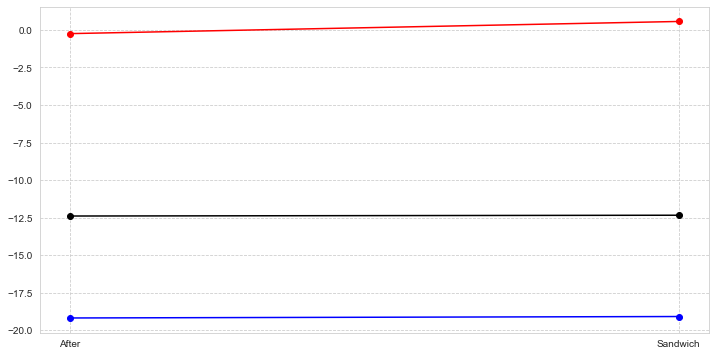

In [97]:
plt.figure (figsize = (12,6))
plt.plot(['After','Sandwich'],[p1a,p1s],'ro-')
plt.plot(['After','Sandwich'],[p2a,p2s],'bo-')
plt.plot(['After','Sandwich'],[p3a,p3s],'ko-')

plt.show()

In [306]:
"""
#aa = df_care.groupby(df_care['seconds'] // 240)
#df_g = pd.DataFrame(columns = aa.groups)
for index,name in aa:
    aaa = aa.get_group(index).mean()
    data = aaa.to_frame()
    df_g[index].append(data)
    #print(index)
    #df_g.append(aaa.to_frame())

    
#df_g = df_g.T
df_g
#aa.groups
#df_g
#df_g.append(aaa.to_frame())


Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Index: []